<a href="https://colab.research.google.com/github/shella688/INT2-GROUP12/blob/main/CNNImageNetwork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np 

import torch
import torchvision # to load datasets 
import torchvision.transforms as transforms
import torch.nn as nn # basic building blocks for neural networks
import torch.nn.functional as F # convolution functions
import torch.optim as optim  # optimiser

In [2]:
# python image librar has range [0,1]
# we want them transformed to tensors of normalised range [-1,1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

batch_size = 4
num_workers = 2

# load training data
flowertrainset = torchvision.datasets.Flowers102(root="./data", split="train",
                                           download=True, transform=transform)
flowertrainloader = torch.utils.data.DataLoader(flowertrainset, batch_size=batch_size,
                                     shuffle=True, num_workers=num_workers)

cifartrainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifartrainloader = torch.utils.data.DataLoader(cifartrainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)


# load test data
flowertestset = torchvision.datasets.Flowers102(root="./data", split="test",
                                          download=True, transform=transform)
flowertestloader = torch.utils.data.DataLoader(flowertestset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


cifartestset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifartestloader = torch.utils.data.DataLoader(cifartestset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



100%|██████████| 344862509/344862509 [00:12<00:00, 28721029.04it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 751442.04it/s]


100%|██████████| 14989/14989 [00:00<00:00, 16466323.38it/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 83456521.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
allLabels = scipy.io.loadmat("/content/data/flowers-102/imagelabels.mat")
labels = allLabels['labels']

flowerClasses = np.unique(labels)


cifarClasses = ("plane", "car", "bird", "cat", "deer", "dog", "frog",
                "horse", "ship", "truck")

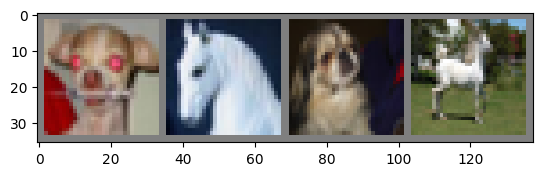

dog horse dog horse


In [4]:
# visualise some images

def imshow(img):
  img = img / 2 + 0.5  # un-normalise 
  npimg = img.numpy()  # convert to numpy object 
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show() 

# get random training images 
dataiter = iter(cifartrainloader)
images, labels = dataiter.__next__()
# the above line doesn't work with Flowers102 because of runtime error
# with tensors being different sizes

imshow(torchvision.utils.make_grid(images))

# print image class
print(' '.join('%s' % cifarClasses[labels[j]] for j in range(batch_size)))

In [5]:
class Net(nn.Module):
  # simple CNN

  def __init__(self):
    super(Net, self).__init__()
    # input has 3 channels (RGB)

    # output has 6 (chosen kinda for fun)
    #   means output will have 6 feature maps

    # 5x5 square convolution kernel 
    #   kernels act as feature detectors from original image

    self.conv1 = nn.Conv2d(3, 6, 5)

    # Maximum pooling over (2,2) area 
    #   reduce dimensions of image allowing assumptions to be made about
    #   features in certain regions of image
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    # fc = fully conencted layer
    self.fc1 = nn.Linear(16*5*5, 120) # we get 5x5 from img dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # relu = rectified linear unit
    #        converts sum of inputs to single output
    #        -ve input == 0, +ve input == input
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    # the network moves like:
    # input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
    # view -> linear -> relu -> linear -> relu -> linear

    # reshape tensor w/ automatic row number and 16*5*5 columns
    x = x.view(-1, 16*5*5)
    # flattens output to give to fc layers
    # could also use x.flatten(1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net() 
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
lossFunc = nn.CrossEntropyLoss()
# CEL combines log softmax and negative log-likelihood
# softmax - scales num to probabilites that add to 1
# log softmax - applies log transformation to softmax probs
# NL-L - calculaes loss based on function range 
#      - small softmax value == large (even infinite) loss
#      - hight softmax value == smaller loss

optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# SGC == Stochastic Gradient Descent

In [7]:
# train network
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):
  # epoch = one pass over entire training set
  # too many can lead to overfitting, too few not enough training

  running_loss = 0.0 

  for i, data in enumerate(cifartrainloader, 0):
    # enumerate over training batches

    # get inputs
    # data is list of [input, label]
    inputs, labels = data 

    # zero gradients to prevent interferenec from past batch 
    optimiser.zero_grad()

    # frward, backward, + optimise 
    outputs = net(inputs)
    loss = lossFunc(outputs, labels)
    loss.backward() 
    optimiser.step() 

    # print stats 
    running_loss += loss.item()
    # extract loss value as python float

    if i % 2000 == 1999:
      # print every 2000 mini-batches
      # means we don't need to calculate gradient of entire dataset
      print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

# stop timing 
end.record() 

# wait for everything to finish 
torch.cuda.synchronize() 

print("DONE")
print(start.elapsed_time(end))

[1,  2000] loss: 2.249
[1,  4000] loss: 1.909
[1,  6000] loss: 1.696
[1,  8000] loss: 1.610
[1, 10000] loss: 1.536
[1, 12000] loss: 1.510
[2,  2000] loss: 1.411
[2,  4000] loss: 1.380
[2,  6000] loss: 1.346
[2,  8000] loss: 1.349
[2, 10000] loss: 1.317
[2, 12000] loss: 1.297
DONE
119868.8125


To save and reload the trained network we can use

`PATH ="./cifarNet.pth"
torch.save(net.state_dict(), PATH)`

and

`net = Net()
net.load_state_dict(torch.load(PATH))`



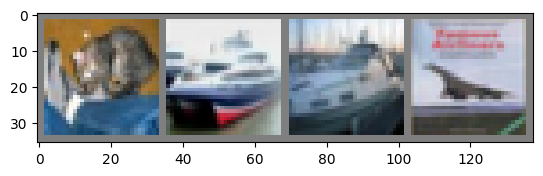

Actual labels:  cat ship ship plane
I predict they are:  dog ship ship plane


In [13]:
# test network on test data

dataiter = iter(cifartestloader)
images, labels = dataiter.__next__()

# print test images 
imshow(torchvision.utils.make_grid(images))
print("Actual labels: ", ' '.join('%s' % 
                                          cifarClasses[labels[j]]
                                          for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, dim=1)
# max value of all elements in output tensor
# dim is axis to find max value, in this case rows

print("I predict they are: ", ' '.join('%s' % 
                                          cifarClasses[predicted[j]]
                                          for j in range(4)))


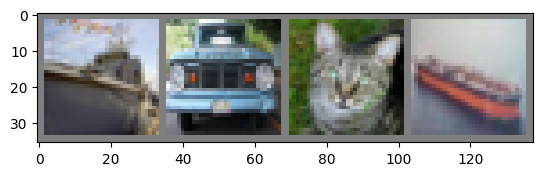

Actual labels:  ship car cat ship
I predict they are:  ship car cat ship


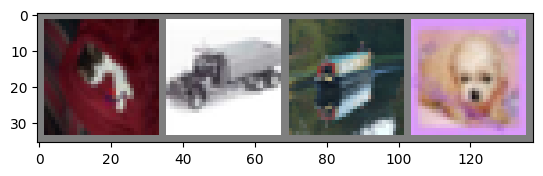

Actual labels:  cat truck ship dog
I predict they are:  dog truck cat cat


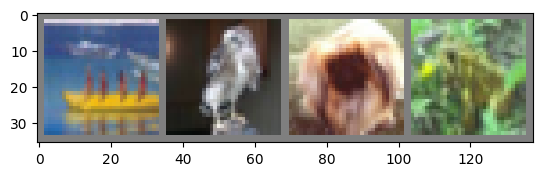

Actual labels:  ship bird dog frog
I predict they are:  ship dog horse frog


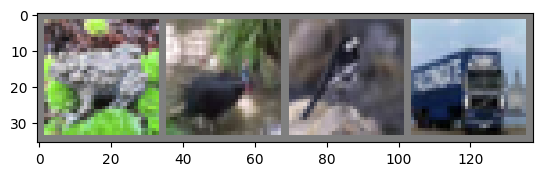

Actual labels:  frog bird bird truck
I predict they are:  frog frog dog truck


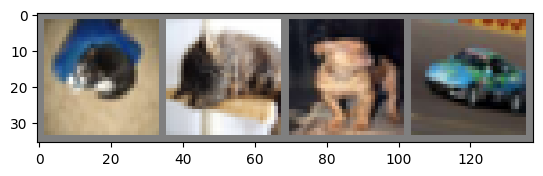

Actual labels:  cat cat dog car
I predict they are:  bird dog dog truck


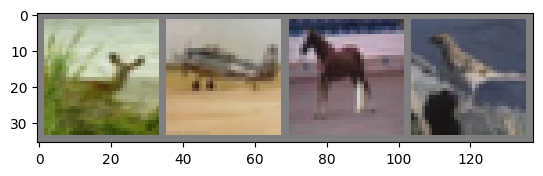

Actual labels:  deer plane horse bird
I predict they are:  deer deer horse ship


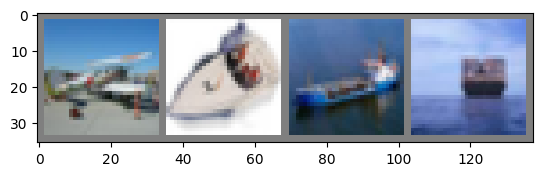

Actual labels:  plane ship ship ship
I predict they are:  plane dog ship plane


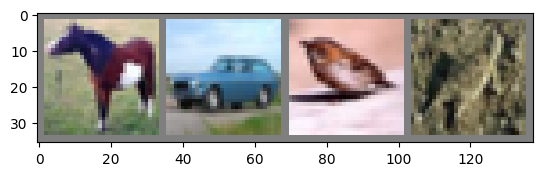

Actual labels:  horse car bird frog
I predict they are:  horse truck plane frog


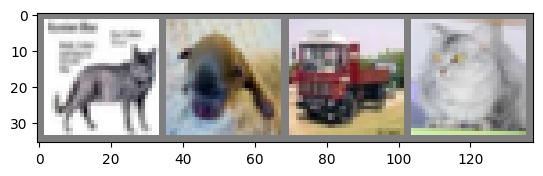

Actual labels:  cat dog truck cat
I predict they are:  horse cat truck cat


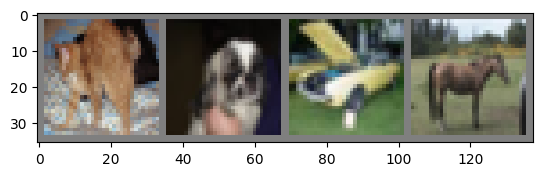

Actual labels:  cat dog car horse
I predict they are:  frog dog deer horse
Accuracy of the network on the 10000 test images: 52 %


In [15]:
from torch.utils.data import dataloader
# now test on 10,000 images 

correct = 0
total = 0 

with torch.no_grad():
  for data in cifartestloader:
    images, labels = data 
    outputs = net(images) 
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0)

    if total % 1000 == 0:
      imshow(torchvision.utils.make_grid(images))
      print("Actual labels: ", ' '.join('%s' % 
                                          cifarClasses[labels[j]]
                                          for j in range(4)))
      print("I predict they are: ", ' '.join('%s' % 
                                          cifarClasses[predicted[j]]
                                          for j in range(4)))



    correct += (predicted == labels).sum().item()


print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))